In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [3]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'), flavor=None)
X_test, y_test = read_data(get_dataset('valid_en'), flavor=None)

2018-12-02 01:19:46,335 [INFO] Reading /opt/storage/english_train.csv..
2018-12-02 01:19:46,561 [INFO] Reading /opt/storage/english_valid.csv..


In [33]:
pd.concat([y_train[x].value_counts(sort=False) for x in y_train], axis=1).sort_index().T.values.tolist()

[[6171, 111, 89, 1629],
 [6346, 55, 44, 1555],
 [6114, 318, 168, 1400],
 [7082, 239, 318, 361],
 [3238, 643, 928, 3191],
 [7467, 83, 125, 325],
 [6745, 431, 187, 637],
 [4023, 944, 1864, 1169],
 [6091, 235, 246, 1428],
 [4846, 147, 1387, 1620],
 [4117, 165, 756, 2962],
 [5622, 232, 375, 1771],
 [4977, 445, 700, 1878],
 [5070, 350, 385, 2195],
 [4325, 727, 717, 2231],
 [370, 336, 3037, 4257],
 [5756, 230, 357, 1657],
 [6455, 170, 140, 1235],
 [165, 684, 1752, 5399],
 [5018, 307, 198, 2477]]

In [36]:
X_train[:1]

0    First of all, the service, I asked the price t...
Name: content, dtype: object

In [3]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [4]:
from fgclassifier.features import FeaturePipeline, logger

for name in ['count_en', 'tfidf_en',
             'lsa_200_en', 'lsa_500_en', 'lsa_1k_en',
             'count_en_sv', 'tfidf_en_sv', 'tfidf_en_sv_dense',
             'lsa_200_en_sv', 'lsa_500_en_sv']:
    logger.info(f'Building features for {name}...')
    model = FeaturePipeline.from_spec(name, cache=fm)
    model.fit_transform(X_train)
    model.transform(X_test)

2018-11-25 20:26:18,610 [INFO] Building features for count_en...
2018-11-25 20:26:18,612 [INFO] Fit & Transform CountVectorizer...
2018-11-25 20:26:35,155 [INFO] Vocab Size: 1828
2018-11-25 20:26:36,907 [INFO] Building features for tfidf_en...
2018-11-25 20:26:36,909 [INFO]   count_en: fit_transform use cache.
2018-11-25 20:26:36,912 [INFO] Fit & Transform TF-IDF...
2018-11-25 20:26:36,992 [INFO]   count_en: transform use cache.
2018-11-25 20:26:37,004 [INFO] Building features for lsa_200_en...
2018-11-25 20:26:37,006 [INFO]   tfidf_en: fit_transform use cache.
2018-11-25 20:26:37,011 [INFO] Fit & Transform TruncatedSVD...
2018-11-25 20:26:40,097 [INFO]   tfidf_en: transform use cache.
2018-11-25 20:26:40,172 [INFO] Building features for lsa_500_en...
2018-11-25 20:26:40,176 [INFO]   tfidf_en: fit_transform use cache.
2018-11-25 20:26:40,177 [INFO] Fit & Transform TruncatedSVD...
2018-11-25 20:26:46,401 [INFO]   tfidf_en: transform use cache.
2018-11-25 20:26:46,458 [INFO] Building fea

Exam the quality of the top terms:

In [5]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count_en', 'count_en_sv']:
    model = fm[mn]['model'].named_steps[mn]
    x_train = fm[mn]['train']
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.2f, max_df: %.2f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:10]]))

Data Shape: (8000,) (2000,)

min_df: 0.01, max_df: 1.00, ngram_range: (1, 4)

vocab size: 1828

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088
store 	 6968
like 	 6532
people 	 6217
dishes 	 5931
really 	 5711

min_df: 0.02, max_df: 1.00, ngram_range: (1, 4)

vocab size: 953

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088
store 	 6968
like 	 6532
people 	 6217
dishes 	 5931
really 	 5711


In [6]:
fm['tfidf_en']['model'].named_steps

{'count_en': FeaturePipeline(steps=count_en),
 'tfidf_en': Tfidf(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}

## The Very Basic TF-IDF + LDA classifier

In [7]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline
from fgclassifier.classifiers import LDA
from fgclassifier.train import fm_cross_check

In [8]:
# Linear Discriminant Analysis, specify the FeaturePipeline
# as steps
model = Baseline(('LDA', LDA), fm=fm['lsa_200_en']['model'])

# Always pass in the original features
# the pipeline will take care of the cashe
model.fit(X_train, y_train)
print(model.name)
print('Final score:', model.score(X_test, y_test))

2018-11-25 20:27:24,869 [INFO]   lsa_200_en: fit_transform use cache.
2018-11-25 20:27:31,505 [INFO]   lsa_200_en: transform use cache.
2018-11-25 20:27:31,534 [INFO] [Validate]: F1 Scores
2018-11-25 20:27:31,537 [INFO]   location_traffic_convenience            	0.4257
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-11-25 20:27:31,545 [INFO]   location_distance_from_business_district	0.3052
2018-11-25 20:27:31,548 [INFO]   location_easy_to_find                   	0.3361
2018-11-25 20:27:31,552 [INFO]   service_wait_time                       	0.3521
2018-11-25 20:27:31,556 [INFO]   service_waiters_attitude                	0.5597
2018-11-25 20:27:31,560 [INFO]   service_parking_convenience             	0.5228
2018-11-25 20:27:31,569 [INFO]   service_serving_speed                   

lsa_200_en_LDA
Final score: 0.408554580419191


## Search for the Best Feature + Classifier Combination

In [9]:
# Run for all classifiers and feature builders
all_avg_scores, all_scores = defaultdict(dict), defaultdict(dict)

In [10]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'avg': all_avg_scores,
        'all': all_scores
    }
}

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
fm_cross_check(
    ['tfidf_en'],
    ['DummyStratified', 'DummyMostFrequent'], **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
fm_cross_check(
    ['tfidf_en', 'tfidf_en_sv'],
    ['MultinomialNB', 'ComplementNB'], **conf)

# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_200_en',
     'lsa_500_en',
     'lsa_1k_en',
     'tfidf_en_sv_dense',
     'lsa_200_en_sv',
     'lsa_500_en_sv',
    ],
    ['LDA', 'LinearSVC', 'Logistic', 'Ridge'], **conf)

2018-11-25 20:27:31,757 [INFO] 
2018-11-25 20:27:31,759 [INFO] ============ Feature Model: tfidf_en ============
2018-11-25 20:27:31,760 [INFO] 
2018-11-25 20:27:31,761 [INFO] Train for tfidf_en -> DummyStratified...
2018-11-25 20:27:31,763 [INFO]   tfidf_en: fit_transform use cache.
2018-11-25 20:27:31,785 [INFO]   tfidf_en: transform use cache.
2018-11-25 20:27:31,800 [INFO] [Validate]: F1 Scores
2018-11-25 20:27:31,803 [INFO]   location_traffic_convenience            	0.2429
2018-11-25 20:27:31,813 [INFO]   location_distance_from_business_district	0.2487
2018-11-25 20:27:31,817 [INFO]   location_easy_to_find                   	0.2467
2018-11-25 20:27:31,820 [INFO]   service_wait_time                       	0.2661
2018-11-25 20:27:31,824 [INFO]   service_waiters_attitude                	0.2555
2018-11-25 20:27:31,828 [INFO]   service_parking_convenience             	0.2548
2018-11-25 20:27:31,831 [INFO]   service_serving_speed                   	0.2582
2018-11-25 20:27:31,837 [INFO] 

2018-11-25 20:27:32,546 [INFO]   environment_decoration                  	0.3989
2018-11-25 20:27:32,549 [INFO]   environment_noise                       	0.3820
2018-11-25 20:27:32,552 [INFO]   environment_space                       	0.4137
2018-11-25 20:27:32,555 [INFO]   environment_cleaness                    	0.4171
2018-11-25 20:27:32,558 [INFO]   dish_portion                            	0.3391
2018-11-25 20:27:32,561 [INFO]   dish_taste                              	0.4798
2018-11-25 20:27:32,564 [INFO]   dish_look                               	0.3142
2018-11-25 20:27:32,567 [INFO]   dish_recommendation                     	0.3272
2018-11-25 20:27:32,570 [INFO]   others_overall_experience               	0.4381
2018-11-25 20:27:32,574 [INFO]   others_willing_to_consume_again         	0.3639
2018-11-25 20:27:32,576 [INFO] ---------------------------------------------------
2018-11-25 20:27:32,577 [INFO] 【tfidf_en -> ComplementNB】: 0.3934
2018-11-25 20:27:32,578 [INFO] ----------

2018-11-25 20:27:40,804 [INFO]   lsa_200_en: fit_transform use cache.
2018-11-25 20:27:59,646 [INFO]   lsa_200_en: transform use cache.
2018-11-25 20:27:59,684 [INFO] [Validate]: F1 Scores
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-11-25 20:27:59,687 [INFO]   location_traffic_convenience            	0.4296
2018-11-25 20:27:59,690 [INFO]   location_distance_from_business_district	0.2787
2018-11-25 20:27:59,692 [INFO]   location_easy_to_find                   	0.3097
2018-11-25 20:27:59,695 [INFO]   service_wait_time                       	0.2990
2018-11-25 20:27:59,698 [INFO]   service_waiters_attitude                	0.5215
2018-11-25 20:27:59,700 [INFO]   service_parking_convenience             	0.3593
2018-11-25 20:27:59,702 [INFO]   service_serving_speed                   

2018-11-25 20:28:41,225 [INFO]   environment_decoration                  	0.4502
2018-11-25 20:28:41,232 [INFO]   environment_noise                       	0.4818
2018-11-25 20:28:41,244 [INFO]   environment_space                       	0.4262
2018-11-25 20:28:41,249 [INFO]   environment_cleaness                    	0.4554
2018-11-25 20:28:41,256 [INFO]   dish_portion                            	0.3856
2018-11-25 20:28:41,262 [INFO]   dish_taste                              	0.4963
2018-11-25 20:28:41,265 [INFO]   dish_look                               	0.3174
2018-11-25 20:28:41,274 [INFO]   dish_recommendation                     	0.3429
2018-11-25 20:28:41,279 [INFO]   others_overall_experience               	0.4644
2018-11-25 20:28:41,297 [INFO]   others_willing_to_consume_again         	0.4253
2018-11-25 20:28:41,299 [INFO] ---------------------------------------------------
2018-11-25 20:28:41,301 [INFO] 【lsa_500_en -> LDA】: 0.4436
2018-11-25 20:28:41,303 [INFO] -----------------

2018-11-25 20:29:49,139 [INFO] 
2018-11-25 20:29:49,140 [INFO] Train for lsa_1k_en -> LDA...
2018-11-25 20:29:49,141 [INFO]   lsa_1k_en: fit_transform use cache.
2018-11-25 20:30:48,857 [INFO]   lsa_1k_en: transform use cache.
2018-11-25 20:30:48,934 [INFO] [Validate]: F1 Scores
2018-11-25 20:30:48,936 [INFO]   location_traffic_convenience            	0.4598
2018-11-25 20:30:48,940 [INFO]   location_distance_from_business_district	0.3610
2018-11-25 20:30:48,943 [INFO]   location_easy_to_find                   	0.4267
2018-11-25 20:30:48,946 [INFO]   service_wait_time                       	0.4041
2018-11-25 20:30:48,948 [INFO]   service_waiters_attitude                	0.5723
2018-11-25 20:30:48,952 [INFO]   service_parking_convenience             	0.4882
2018-11-25 20:30:48,955 [INFO]   service_serving_speed                   	0.4925
2018-11-25 20:30:48,958 [INFO]   price_level                             	0.5519
2018-11-25 20:30:48,962 [INFO]   price_cost_effective                   

2018-11-25 20:33:35,703 [INFO]   environment_noise                       	0.4427
2018-11-25 20:33:35,706 [INFO]   environment_space                       	0.3421
2018-11-25 20:33:35,711 [INFO]   environment_cleaness                    	0.3808
2018-11-25 20:33:35,715 [INFO]   dish_portion                            	0.3078
2018-11-25 20:33:35,719 [INFO]   dish_taste                              	0.3630
2018-11-25 20:33:35,725 [INFO]   dish_look                               	0.2592
2018-11-25 20:33:35,728 [INFO]   dish_recommendation                     	0.2862
2018-11-25 20:33:35,731 [INFO]   others_overall_experience               	0.3836
2018-11-25 20:33:35,734 [INFO]   others_willing_to_consume_again         	0.2952
2018-11-25 20:33:35,737 [INFO] ---------------------------------------------------
2018-11-25 20:33:35,738 [INFO] 【lsa_1k_en -> Ridge】: 0.3627
2018-11-25 20:33:35,739 [INFO] ---------------------------------------------------
2018-11-25 20:33:35,742 [INFO] 
2018-11-25 20

2018-11-25 20:36:13,750 [INFO] [Validate]: F1 Scores
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-11-25 20:36:13,758 [INFO]   location_traffic_convenience            	0.4186
2018-11-25 20:36:13,761 [INFO]   location_distance_from_business_district	0.3061
2018-11-25 20:36:13,765 [INFO]   location_easy_to_find                   	0.3198
2018-11-25 20:36:13,768 [INFO]   service_wait_time                       	0.3230
2018-11-25 20:36:13,773 [INFO]   service_waiters_attitude                	0.5106
2018-11-25 20:36:13,776 [INFO]   service_parking_convenience             	0.3558
2018-11-25 20:36:13,784 [INFO]   service_serving_speed                   	0.3907
2018-11-25 20:36:13,795 [INFO]   price_level                             	0.4373
2018-11-25 20:36:13,801 [INFO]   price_cost_eff

2018-11-25 20:36:48,888 [INFO]   price_cost_effective                    	0.3497
2018-11-25 20:36:48,891 [INFO]   price_discount                          	0.4304
2018-11-25 20:36:48,894 [INFO]   environment_decoration                  	0.3750
2018-11-25 20:36:48,900 [INFO]   environment_noise                       	0.3543
2018-11-25 20:36:48,905 [INFO]   environment_space                       	0.3474
2018-11-25 20:36:48,909 [INFO]   environment_cleaness                    	0.3552
2018-11-25 20:36:48,911 [INFO]   dish_portion                            	0.3173
2018-11-25 20:36:48,913 [INFO]   dish_taste                              	0.4066
2018-11-25 20:36:48,916 [INFO]   dish_look                               	0.2660
2018-11-25 20:36:48,918 [INFO]   dish_recommendation                     	0.2975
2018-11-25 20:36:48,925 [INFO]   others_overall_experience               	0.4191
2018-11-25 20:36:48,938 [INFO]   others_willing_to_consume_again         	0.3190
2018-11-25 20:36:48,938 [INF

2018-11-25 20:37:46,237 [INFO] Train for lsa_500_en_sv -> Logistic...
2018-11-25 20:37:46,239 [INFO]   lsa_500_en_sv: fit_transform use cache.
2018-11-25 20:38:06,121 [INFO]   lsa_500_en_sv: transform use cache.
2018-11-25 20:38:06,194 [INFO] [Validate]: F1 Scores
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-11-25 20:38:06,199 [INFO]   location_traffic_convenience            	0.4236
2018-11-25 20:38:06,201 [INFO]   location_distance_from_business_district	0.3186
2018-11-25 20:38:06,205 [INFO]   location_easy_to_find                   	0.3373
2018-11-25 20:38:06,209 [INFO]   service_wait_time                       	0.3209
2018-11-25 20:38:06,212 [INFO]   service_waiters_attitude                	0.5706
2018-11-25 20:38:06,228 [INFO]   service_parking_convenience             	0.34

In [11]:
rows = {}
for fm_name in all_scores:
    for clf_name in all_scores[fm_name]:
        key = f'{fm_name}.{clf_name}'
        rows[key] = [all_avg_scores[fm_name][clf_name],
                     *all_scores[fm_name][clf_name]]
df = pd.DataFrame(rows)
df.index = ['average', *y_train.columns]
df = df.T.sort_values('average', ascending=False)
df

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
lsa_1k_en.LDA,0.453141,0.459793,0.361036,0.426699,0.404150,0.572290,0.488198,0.492477,0.551945,0.440951,...,0.476267,0.539153,0.476310,0.456399,0.371461,0.482942,0.320933,0.356111,0.466907,0.424864
tfidf_en_sv_dense.LDA,0.452059,0.477528,0.347123,0.400027,0.393032,0.574967,0.506034,0.517208,0.529595,0.457688,...,0.463803,0.537253,0.512397,0.466104,0.384584,0.485399,0.312781,0.338334,0.442633,0.403872
lsa_500_en_sv.LDA,0.447956,0.471323,0.337645,0.403305,0.387129,0.580478,0.497902,0.510106,0.516331,0.440619,...,0.464552,0.540759,0.431787,0.446316,0.369254,0.517725,0.327245,0.342152,0.458055,0.414842
lsa_500_en.LDA,0.443577,0.460054,0.354251,0.403038,0.391485,0.584698,0.492965,0.484079,0.521448,0.434645,...,0.450226,0.481795,0.426212,0.455397,0.385554,0.496339,0.317361,0.342890,0.464359,0.425344
tfidf_en_sv_dense.LinearSVC,0.425451,0.450413,0.349908,0.358974,0.364913,0.553100,0.478931,0.451868,0.518109,0.401121,...,0.418813,0.500743,0.465476,0.428510,0.361297,0.466410,0.300741,0.346292,0.445406,0.373484
lsa_1k_en.LinearSVC,0.418100,0.431894,0.356357,0.372678,0.352807,0.556535,0.433971,0.440506,0.532333,0.378033,...,0.437877,0.470046,0.427788,0.423085,0.361553,0.448596,0.307313,0.349562,0.458126,0.344150
lsa_200_en_sv.LDA,0.413421,0.442967,0.307489,0.347131,0.357260,0.555679,0.540193,0.444716,0.465090,0.400562,...,0.403449,0.385227,0.391751,0.419358,0.348970,0.496249,0.311300,0.342201,0.441208,0.391025
lsa_200_en.LDA,0.408555,0.425669,0.305197,0.336108,0.352089,0.559688,0.522826,0.440732,0.469075,0.386088,...,0.408713,0.391386,0.387300,0.411796,0.347187,0.491139,0.299019,0.329105,0.444436,0.390391
lsa_500_en_sv.LinearSVC,0.405671,0.430352,0.324205,0.344542,0.355465,0.553171,0.429659,0.442150,0.494162,0.397831,...,0.412402,0.454166,0.391518,0.401961,0.345336,0.464817,0.280971,0.336970,0.442498,0.336076
tfidf_en_sv_dense.Logistic,0.396071,0.425318,0.334421,0.355883,0.344940,0.560615,0.361576,0.432355,0.492383,0.349402,...,0.414269,0.405024,0.419524,0.390364,0.346971,0.434079,0.287249,0.334020,0.441034,0.336609


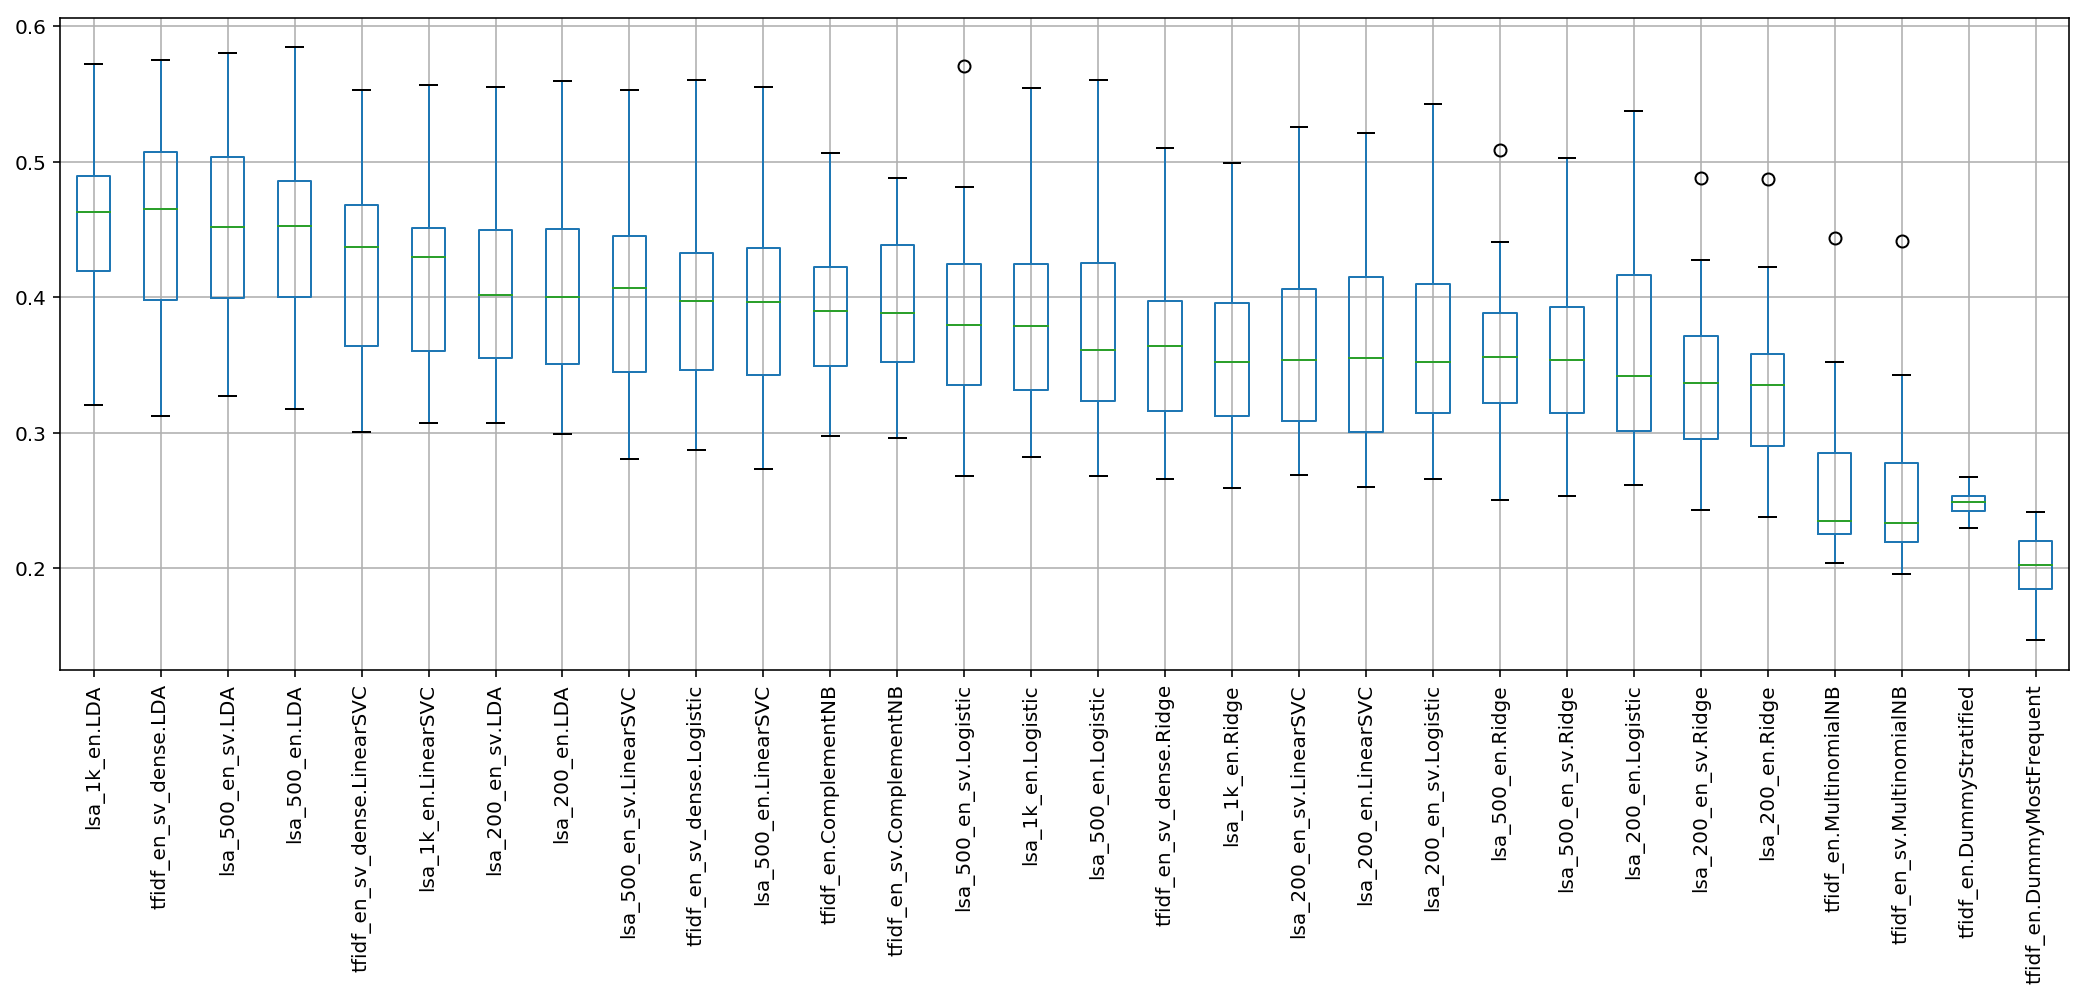

In [12]:
import matplotlib.pyplot as plt

df.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [58]:
from fgclassifier.utils import save_model

def clear_cache(model):
    while hasattr(model, 'steps'):
        for (name, model) in model.steps:
            clear_cache(model)
    if hasattr(model, 'cache'):
        model.cache = None

for name, model in results['models'].items():
    clear_cache(model)
    save_model(model)

2018-11-25 21:41:11,694 [INFO] Saving model to data/models/tfidf_en_DummyStratified.pkl...
2018-11-25 21:41:25,749 [INFO] Saving model... Done.
2018-11-25 21:41:25,751 [INFO] Saving model to data/models/tfidf_en_DummyMostFrequent.pkl...
2018-11-25 21:41:39,742 [INFO] Saving model... Done.
2018-11-25 21:41:39,743 [INFO] Saving model to data/models/tfidf_en_MultinomialNB.pkl...
2018-11-25 21:41:53,095 [INFO] Saving model... Done.
2018-11-25 21:41:53,097 [INFO] Saving model to data/models/tfidf_en_ComplementNB.pkl...
2018-11-25 21:42:06,989 [INFO] Saving model... Done.
2018-11-25 21:42:06,991 [INFO] Saving model to data/models/tfidf_en_sv_MultinomialNB.pkl...
2018-11-25 21:42:20,456 [INFO] Saving model... Done.
2018-11-25 21:42:20,458 [INFO] Saving model to data/models/tfidf_en_sv_ComplementNB.pkl...
2018-11-25 21:42:35,275 [INFO] Saving model... Done.
2018-11-25 21:42:35,277 [INFO] Saving model to data/models/lsa_200_en_LDA.pkl...
2018-11-25 21:42:49,702 [INFO] Saving model... Done.
2018

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [42]:
model = results['models']['lsa_500_en_LDA']
probas = [x.tolist() for x in model.predict_proba(X_test[0:1])]
probas

2018-11-25 21:36:25,611 [INFO]   count_en: transform use cache.


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [57]:
model.predict(X_test[0:1])

array([[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,  1,
        -2, -2,  1, -2]])